In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
import json
import os
import fiona
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db+'?sslmode=disable', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

In [2]:
db, conn = pgconnect(credentials)

Connected successfully.


In [3]:
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [4]:
def split(word):
    if type(word)==int:
        word=str(word)
    return [char for char in word]
def toInt(st):
    parts=split(st)
    if parts.count(",")>0:
        parts.remove(",")
    i=0
    num=0
    while i<len(parts):
        num+=10**(len(parts)-i-1)* int(parts[i])
        i+=1
    return num

In [5]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [6]:
conn.execute("""
DROP TABLE  BusinessStats cascade;
CREATE TABLE BusinessStats(
   area_id INTEGER,
   area_name VARCHAR(50),
   number_of_businesses INTEGER,
   accommodation_and_food_services INTEGER,
   retail_trade INTEGER,
   agriculture_forestry_and_fishing INTEGER,
   health_care_and_social_assistance INTEGER,
   public_administration_and_safety INTEGER,
   transport_postal_and_warehousing INTEGER,
   primary key(area_id,area_name)
);""")


In [7]:
businessdata = pd.read_csv('BusinessStats.csv')
businessdata.to_sql("businessstats", con=conn, if_exists='append', index=False)
businessdata

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [8]:
conn.execute("""
DROP TABLE Neighbourhoods cascade;
CREATE TABLE Neighbourhoods(
    "Unnamed: 0" Integer,
   area_id INTEGER ,
   area_name VARCHAR(50),
   land_area FLOAT,
   number_of_businesses INTEGER,
   median_annual_household_income INTEGER,
   avg_monthly_rent INTEGER,
   "0-4" INTEGER,
   "5-9" INTEGER,
   "10-14" INTEGER,
   "15-19" INTEGER,
   primary key(area_id,area_name)
);""")
ls=["Unnamed: 0","area_id","area_name","land_area","number_of_businesses","median_annual_household_income","avg_monthly_rent","0-4","5-9","10-14","15-19"]
Neighbourhoodsdata = pd.read_csv('Neighbourhoods.csv',usecols=ls)
Neighbourhoodsdata.fillna(0, inplace = True)
Neighbourhoodsdata.to_sql("neighbourhoods", con=conn, if_exists='append', index=False)
population=pd.read_csv('Neighbourhoods.csv',usecols=["population"])
dwelling=pd.read_csv('Neighbourhoods.csv',usecols=["number_of_dwellings"])
population.fillna(0, inplace = True)
dwelling.fillna(0, inplace = True)


In [9]:
conn.execute("""
ALter table neighbourhoods
ADD population INTEGER
""")
conn.execute("""
ALter table neighbourhoods
ADD number_of_dwellings INTEGER
""")

In [10]:
i=0
while i<322:
    pop=toInt(population.loc[i]["population"])
    conn.execute("""
    Update neighbourhoods
    set population = {}
    where "Unnamed: 0" ={}""".format(pop,i))
    dwellings=toInt(dwelling.loc[i]["number_of_dwellings"])
    conn.execute("""
    Update neighbourhoods
    set number_of_dwellings = {}
    where "Unnamed: 0" ={}""".format(dwellings,i))
    i+=1
conn.execute("""
ALter table neighbourhoods
drop column "Unnamed: 0"
""")
query(conn,"""select * from neighbourhoods""")

,area_id,area_name,land_area,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19,population,number_of_dwellings
0,102011028,Avoca Beach - Copacabana,643.8000,738,46996,1906,467,583,604,560,7590,2325
1,102011029,Box Head - MacMasters Beach,3208.6000,907,42621,1682,586,696,661,692,10986,3847
2,102011030,Calga - Kulnura,76795.1000,1102,42105,1182,220,254,304,320,4841,1575
3,102011031,Erina - Green Point,3379.3000,1666,43481,1595,695,778,916,838,14237,4450
4,102011032,Gosford - Springfield,1691.2000,2126,45972,1382,1200,1079,963,977,19385,6373
...,...,...,...,...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,673,73164,1080,432,590,577,527,7931,3281
318,106011113,Singleton Region,4067.2349,698,87984,1000,310,394,353,323,4919,2055
319,111021218,Morisset - Cooranbong,330.5208,1154,58084,1260,813,855,828,962,14959,6298
320,114021285,Hill Top - Colo Vale,174.3752,400,81120,1512,443,500,470,451,6025,2249


In [11]:
SA2_data = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
SA2_data = SA2_data.replace(to_replace='None', value=np.nan).dropna()
SA2_data

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,"POLYGON ((148.80406 -35.37620, 148.80416 -35.3..."
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,"POLYGON ((105.67392 -10.41567, 105.67398 -10.4..."
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."


In [12]:
SA2_og = SA2_data.copy()  # creating a copy of the original for later
SA2_data['geom'] = SA2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4283))  # applying the function
SA2_data = SA2_data.drop(columns="geometry")  # deleting the old copy
SA2_data

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,MULTIPOLYGON (((149.58423299700007 -35.4442699...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,MULTIPOLYGON (((149.23580096700005 -35.3873753...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,MULTIPOLYGON (((148.80406400200002 -35.3762040...
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,MULTIPOLYGON (((105.67391901000008 -10.4156730...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,MULTIPOLYGON (((96.83046599400006 -12.17635995...
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,MULTIPOLYGON (((150.6956629970001 -35.18296700...


In [13]:
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    "SA2_MAIN16" INTEGER primary key, 
    "SA2_5DIG16" INTEGER, 
    "SA2_NAME16" VARCHAR(50), 
    "SA3_CODE16" NUMERIC, 
    "SA3_NAME16" VARCHAR(50),
    "SA4_CODE16" NUMERIC,
    "SA4_NAME16" VARCHAR(50),
    "GCC_CODE16" VARCHAR(10),
    "GCC_NAME16" VARCHAR(50),
    "STE_CODE16" NUMERIC,
    "STE_NAME16" VARCHAR(50),
    "AREASQKM16" NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);""")

In [14]:
SA2_data.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4283)})
query(conn, "select * from sa2")

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geom
0,101021007,11007,Braidwood,10102.0,Queanbeyan,101.0,Capital Region,1RNSW,Rest of NSW,1.0,New South Wales,3418.3525,0106000020BB100000010000000103000000010000005F...
1,101021008,11008,Karabar,10102.0,Queanbeyan,101.0,Capital Region,1RNSW,Rest of NSW,1.0,New South Wales,6.9825,0106000020BB100000010000000103000000010000002C...
2,101031016,11016,Jindabyne - Berridale,10103.0,Snowy Mountains,101.0,Capital Region,1RNSW,Rest of NSW,1.0,New South Wales,3939.5484,0106000020BB100000010000000103000000010000005F...
3,101041017,11017,Batemans Bay,10104.0,South Coast,101.0,Capital Region,1RNSW,Rest of NSW,1.0,New South Wales,63.7074,0106000020BB1000000100000001030000000100000036...
4,101041018,11018,Batemans Bay - South,10104.0,South Coast,101.0,Capital Region,1RNSW,Rest of NSW,1.0,New South Wales,30.5948,0106000020BB100000070000000103000000010000001C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,801111141,81141,Namadgi,80111.0,Urriarra - Namadgi,801.0,Australian Capital Territory,8ACTE,Australian Capital Territory,8.0,Australian Capital Territory,1202.8930,0106000020BB100000010000000103000000010000000C...
2288,901011001,91001,Christmas Island,90101.0,Christmas Island,901.0,Other Territories,9OTER,Other Territories,9.0,Other Territories,136.1356,0106000020BB1000000100000001030000000100000094...
2289,901021002,91002,Cocos (Keeling) Islands,90102.0,Cocos (Keeling) Islands,901.0,Other Territories,9OTER,Other Territories,9.0,Other Territories,13.7163,0106000020BB100000380000000103000000010000000E...
2290,901031003,91003,Jervis Bay,90103.0,Jervis Bay,901.0,Other Territories,9OTER,Other Territories,9.0,Other Territories,67.8134,0106000020BB1000000300000001030000000100000017...


In [15]:
schoolsdata = pd.concat(
map(gpd.read_file, ['school_catchments/catchments_primary.shp', 'school_catchments/catchments_secondary.shp', 'school_catchments/catchments_future.shp']), ignore_index=True)
schoolsdata

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.26653 -35.49838, 149.26703 -35.5..."
2141,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.14237 -35.56872, 149.16075 -35.5..."
2142,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.19808 -35.38147, 149.19852 -35.3..."
2143,8919,HIGH_COED,Bungendore HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9..."


In [16]:
schoolsdata_og = schoolsdata.copy()  
schoolsdata['geom'] = schoolsdata['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4283))  
schoolsdata = schoolsdata.drop(columns="geometry") 
schoolsdata

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.14085043012102 -33.7446267...
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,MULTIPOLYGON (((149.26653458527704 -35.4983768...
2141,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,MULTIPOLYGON (((149.14237305771536 -35.5687160...
2142,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,MULTIPOLYGON (((149.1980792584528 -35.38147320...
2143,8919,HIGH_COED,Bungendore HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,MULTIPOLYGON (((149.2408471104619 -34.91439387...


In [17]:
conn.execute("""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    "USE_ID" NUMERIC, 
    "CATCH_TYPE" VARCHAR(20), 
    "USE_DESC" VARCHAR(50), 
    "ADD_DATE" NUMERIC, 
    "KINDERGART" VARCHAR(10),
    "YEAR1" VARCHAR(10),
    "YEAR2" VARCHAR(10),
    "YEAR3" VARCHAR(10),
    "YEAR4" VARCHAR(10),
    "YEAR5" VARCHAR(10),
    "YEAR6" VARCHAR(10),
    "YEAR7" VARCHAR(10),
    "YEAR8" VARCHAR(10),
    "YEAR9" VARCHAR(10),
    "YEAR10" VARCHAR(10),
    "YEAR11" VARCHAR(10),
    "YEAR12" VARCHAR(10),
    "PRIORITY" VARCHAR(10),
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)

In [18]:
schoolsdata.to_sql("schools", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4283)})
query(conn, "select * from schools")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838.0,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000078...
1,3943.0,PRIMARY,Gordon WPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000006F...
2,2404.0,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000BE...
3,1839.0,PRIMARY,Empire Bay PS,20211115.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000032...
4,4393.0,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000065...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8524.0,HIGH_COED,Karabar HS,20220305.0,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000006E...
2141,4680.0,PRIMARY,Googong PS,20220305.0,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB1000000100000001030000000100000072...
2142,2540.0,PRIMARY,Michelago PS,20220305.0,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB10000001000000010300000001000000BF...
2143,8922.0,HIGH_COED,Jerrabomberra HS,20220305.0,0,0,0,0,0,0,0,2023,2023,0,0,0,0,None,0106000020BB1000000100000001030000000100000020...


In [19]:
breakdata = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")
breakdata = breakdata.replace(to_replace='None', value=np.nan).dropna()
breakdata

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,10.0,High Density,3,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,10.0,High Density,3,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,10.0,High Density,3,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


In [20]:
srid=4283
breakdata_og = breakdata.copy()  
breakdata['geom'] = breakdata['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  
breakdata = breakdata.drop(columns="geometry") 
breakdata

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
0,1,8.0,Low Density,1,0.012138,0.000006,MULTIPOLYGON (((149.91078014700008 -37.0663631...
1,2,8.0,Low Density,1,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,8.0,Low Density,1,0.006068,0.000002,MULTIPOLYGON (((148.94249939000008 -37.0420853...
3,4,8.0,Low Density,1,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,8.0,Low Density,1,0.008073,0.000003,MULTIPOLYGON (((149.84836006500007 -36.6845891...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,MULTIPOLYGON (((153.27961053500007 -28.5538784...
2590,2591,10.0,High Density,3,0.028327,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,10.0,High Density,3,0.006654,0.000002,MULTIPOLYGON (((153.56824816100004 -28.3830681...
2592,2593,10.0,High Density,3,0.047098,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


In [21]:
conn.execute("""
DROP table break_enter cascade;
CREATE TABLE break_enter (
    "OBJECTID" NUMERIC primary key, 
    "Contour" NUMERIC, 
    "Density" VARCHAR(20), 
    "ORIG_FID" NUMERIC, 
    "Shape_Leng" NUMERIC,
    "Shape_Area" NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)

In [22]:
breakdata.to_sql("break_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from break_enter")

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
0,1.0,8.0,Low Density,1.0,0.012138,0.000006,0106000020BB1000000100000001030000000100000015...
1,2.0,8.0,Low Density,1.0,0.019106,0.000015,0106000020BB100000010000000103000000010000001D...
2,3.0,8.0,Low Density,1.0,0.006068,0.000002,0106000020BB1000000100000001030000000100000007...
3,4.0,8.0,Low Density,1.0,0.011006,0.000006,0106000020BB100000010000000103000000010000000E...
4,5.0,8.0,Low Density,1.0,0.008073,0.000003,0106000020BB100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590.0,10.0,High Density,3.0,0.015358,0.000011,0106000020BB1000000100000001030000000100000016...
2590,2591.0,10.0,High Density,3.0,0.028327,0.000029,0106000020BB1000000100000001030000000100000028...
2591,2592.0,10.0,High Density,3.0,0.006654,0.000002,0106000020BB1000000100000001030000000100000009...
2592,2593.0,10.0,High Density,3.0,0.047098,0.000044,0106000020BB100000010000000103000000010000004D...


In [23]:
bicycle_data = gpd.read_file('Bicycle_count_sites.geojson')
bicycle_data

,OBJECTID,SiteID,Intersection,geometry
0,1,1,"Intersection of Broadway, Lee Street, Quay Str...",POINT (151.20417 -33.88285)
1,2,2,Intersection of Castlereagh Street and Goulbur...,POINT (151.20860 -33.87829)
2,3,3,Intersection of Grosvenor Street and Glouceste...,POINT (151.20578 -33.86336)
3,4,4,Intersection of Elizabeth Street and Park Street,POINT (151.20990 -33.87329)
4,5,5,"Intersection of Elizabeth Street, Wentworth Av...",POINT (151.20908 -33.87980)
...,...,...,...,...
104,105,34,Intersection of Buckland Street and Myrtle Str...,POINT (151.19689 -33.88740)
105,106,81,Intersection of Elizabeth Street and Redfern S...,POINT (151.20730 -33.89324)
106,107,95,Intersection of Bourke Street and O'Dea Avenue...,POINT (151.20726 -33.90308)
107,108,108,Intersection of Riley St and Campbell St,POINT (151.21374 -33.88064)


In [24]:
bicycle_data['geom'] = bicycle_data['geometry'].apply(lambda x: WKTElement(x.wkt, 4283))
bicycle_data = bicycle_data.drop(columns="geometry")
bicycle_data

,OBJECTID,SiteID,Intersection,geom
0,1,1,"Intersection of Broadway, Lee Street, Quay Str...",POINT (151.204167807883 -33.8828455608817)
1,2,2,Intersection of Castlereagh Street and Goulbur...,POINT (151.20860123036 -33.8782857820077)
2,3,3,Intersection of Grosvenor Street and Glouceste...,POINT (151.205782587883 -33.863364269264)
3,4,4,Intersection of Elizabeth Street and Park Street,POINT (151.209897088493 -33.8732920555973)
4,5,5,"Intersection of Elizabeth Street, Wentworth Av...",POINT (151.209083421334 -33.8797971180193)
...,...,...,...,...
104,105,34,Intersection of Buckland Street and Myrtle Str...,POINT (151.196889881624 -33.8874041392399)
105,106,81,Intersection of Elizabeth Street and Redfern S...,POINT (151.20729817291 -33.8932424424646)
106,107,95,Intersection of Bourke Street and O'Dea Avenue...,POINT (151.207259959364 -33.9030759990065)
107,108,108,Intersection of Riley St and Campbell St,POINT (151.213744628583 -33.8806374495123)


In [25]:
conn.execute("""
DROP TABLE IF EXISTS bicycles cascade;
CREATE TABLE bicycles (
    "OBJECTID" NUMERIC primary key, 
    "SiteID" NUMERIC, 
    "Intersection" VARCHAR(150),
    geom GEOMETRY(POINT,4283)
);"""
)
bicycle_data.to_sql('bicycles', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})
query(conn, "select * from bicycles")


,OBJECTID,SiteID,Intersection,geom
0,1.0,1.0,"Intersection of Broadway, Lee Street, Quay Str...",0101000020BB1000001D38ED8A88E66240EDB3551501F1...
1,2.0,2.0,Intersection of Castlereagh Street and Goulbur...,0101000020BB100000A6C97CDCACE66240E72123AB6BF0...
2,3.0,3.0,Intersection of Grosvenor Street and Glouceste...,0101000020BB10000066A15DC595E662400C836AB882EE...
3,4.0,4.0,Intersection of Elizabeth Street and Park Street,0101000020BB1000004C53197AB7E66240D152B908C8EF...
4,5.0,5.0,"Intersection of Elizabeth Street, Wentworth Av...",0101000020BB1000007D18B7CFB0E66240048124319DF0...
...,...,...,...,...
104,105.0,34.0,Intersection of Buckland Street and Myrtle Str...,0101000020BB100000A14F02EC4CE66240692F767596F1...
105,106.0,81.0,Intersection of Elizabeth Street and Redfern S...,0101000020BB1000006825C72FA2E662406EE4B2C455F2...
106,107.0,95.0,Intersection of Bourke Street and O'Dea Avenue...,0101000020BB100000A367A3DFA1E6624089C48CFE97F3...
107,108.0,108.0,Intersection of Riley St and Campbell St,0101000020BB100000B5AEF9FED6E66240E3A45ABAB8F0...


In [26]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
playground_data = gpd.read_file('Playgrounds.kml', driver='KML')
playground_data

,Name,Description,geometry
0,McKell Playground B,,POINT (151.19673 -33.89968)
1,Minogue Crescent Reserve Playground,,POINT (151.17687 -33.88040)
2,May Pitt Playground,,POINT (151.18167 -33.88391)
3,Clyne Reserve Playground,,POINT (151.20173 -33.85694)
4,Shannon Reserve Playground,,POINT (151.21424 -33.88579)
...,...,...,...
146,Redfern Park Playground C,,POINT (151.20667 -33.89515)
147,Frances Newton Playground,,POINT (151.21692 -33.87717)
148,Turruwul Park Playground,,POINT (151.20458 -33.91856)
149,Waterloo Park & Mount Carmel Fitness Station,,POINT (151.20448 -33.89963)


In [27]:
playground_data['geom'] = playground_data['geometry'].apply(lambda x: WKTElement(x.wkt, 4283))
playground_data = playground_data.drop(columns="geometry")
playground_data

,Name,Description,geom
0,McKell Playground B,,POINT (151.19672847458 -33.899676710873)
1,Minogue Crescent Reserve Playground,,POINT (151.176866581914 -33.8803964500307)
2,May Pitt Playground,,POINT (151.181666086631 -33.88390708567)
3,Clyne Reserve Playground,,POINT (151.20173393524 -33.8569368835388)
4,Shannon Reserve Playground,,POINT (151.214240083107 -33.8857875089495)
...,...,...,...
146,Redfern Park Playground C,,POINT (151.206674978278 -33.8951496429259)
147,Frances Newton Playground,,POINT (151.216922453289 -33.8771749885363)
148,Turruwul Park Playground,,POINT (151.204575308304 -33.9185647639693)
149,Waterloo Park & Mount Carmel Fitness Station,,POINT (151.204482093686 -33.8996320727047)


In [28]:
conn.execute("""
DROP TABLE IF EXISTS playgrounds;
CREATE TABLE playgrounds (
    "Name" VARCHAR(80), 
    "Description" VARCHAR(50), 
    geom GEOMETRY(POINT,4283)
);"""
)
playground_data.to_sql('playgrounds', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})
query(conn, "select * from playgrounds")

,Name,Description,geom
0,McKell Playground B,,0101000020BB1000006B9083994BE662401116419B28F3...
1,Minogue Crescent Reserve Playground,,0101000020BB1000006E221BE4A8E56240BC32B4D4B0F0...
2,May Pitt Playground,,0101000020BB100000EB9B6535D0E56240E2D30CDE23F1...
3,Clyne Reserve Playground,,0101000020BB1000002CCBB99A74E6624085C4981BB0ED...
4,Shannon Reserve Playground,,0101000020BB100000FBCD040EDBE662405B122F7C61F1...
...,...,...,...
146,Redfern Park Playground C,,0101000020BB1000006013D8149DE6624048B2744394F2...
147,Frances Newton Playground,,0101000020BB1000009E545B07F1E66240F850204547F0...
148,Turruwul Park Playground,,0101000020BB100000835784E18BE66240C840BA8793F5...
149,Waterloo Park & Mount Carmel Fitness Station,,0101000020BB100000F81F081E8BE662408559CD2427F3...


In [29]:
conn.execute("""
DROP INDEX IF EXISTS sa2_geom_idx;
CREATE INDEX sa2_geom_idx ON sa2 USING GIST (geom);
""")
conn.execute("""
DROP INDEX IF EXISTS break_geom_idx;
CREATE INDEX break_geom_idx ON break_enter USING GIST (geom);
""")
conn.execute("""
DROP INDEX IF EXISTS school_geom_idx;
CREATE INDEX school_geom_idx ON schools USING GIST (geom);
""")
conn.execute("""
DROP INDEX IF EXISTS bicycle_geom_idx;
CREATE INDEX bicycle_geom_idx ON bicycles USING GIST (geom);
""")
conn.execute("""
DROP INDEX IF EXISTS playground_geom_idx;
CREATE INDEX playground_geom_idx ON playgrounds USING GIST (geom);
""")

In [30]:
conn.execute("""
drop view if exists school_view cascade""")
conn.execute( """
CREATE VIEW school_view AS
SELECT A."SA2_MAIN16" as area_id, count(*), (C."0-4" + C."5-9" + C."10-14" + C."15-19") AS total, COALESCE(1000*count(*)/NULLIF((C."0-4" + C."5-9" + C."10-14" + C."15-19"), 0),0) AS school
FROM sa2 A JOIN schools B ON ST_Intersects(A.geom, B.geom)
JOIN neighbourhoods C ON A."SA2_MAIN16"=C.area_id
GROUP BY A."SA2_MAIN16", total
""")

In [31]:
query(conn,"""
select * from school_view
""")

,area_id,count,total,school
0,101051540,39,3090,12
1,102011028,6,2214,2
2,102011029,8,2635,3
3,102011030,27,1098,24
4,102011031,17,3227,5
...,...,...,...,...
317,128021537,19,8,2375
318,128021538,17,4894,3
319,128021607,13,5176,2
320,128021608,8,2054,3


In [32]:
conn.execute("""
drop view if exists bicycle_view cascade""")
conn.execute( """
CREATE VIEW bicycle_view AS
SELECT C.area_id, count(*) as bicycle_sites
FROM sa2 A JOIN bicycles B ON ST_Contains(A.geom, B.geom)
right JOIN neighbourhoods C ON A."SA2_MAIN16"=C.area_id
GROUP BY C.area_id
""")

In [33]:
query(conn,"""
select * from bicycle_view
""")

,area_id,bicycle_sites
0,101051540,1
1,102011028,1
2,102011029,1
3,102011030,1
4,102011031,1
...,...,...
317,128021537,1
318,128021538,1
319,128021607,1
320,128021608,1


In [34]:
conn.execute("""
drop view if exists playground_view cascade""")
conn.execute( """
CREATE VIEW playground_view AS
SELECT C.area_id, count(*) as playground_sites
FROM sa2 A JOIN playgrounds B ON ST_Contains(A.geom, B.geom)
right JOIN neighbourhoods C ON A."SA2_MAIN16"=C.area_id
GROUP BY C.area_id
""")

In [35]:
query(conn,"""
select * from playground_view
""")

,area_id,playground_sites
0,101051540,1
1,102011028,1
2,102011029,1
3,102011030,1
4,102011031,1
...,...,...
317,128021537,1
318,128021538,1
319,128021607,1
320,128021608,1


In [36]:
conn.execute("""
drop view if exists acc_view cascade""")
conn.execute("""
create view acc_view as
SELECT A.area_id, A.accommodation_and_food_services, B.population, COALESCE(1000*A.accommodation_and_food_services/NULLIF(B.population, 0),0) AS accom
FROM businessstats A JOIN neighbourhoods B using(area_id)
""")

In [37]:
query(conn,"""
select * from acc_view""")

,area_id,accommodation_and_food_services,population,accom
0,101051540,38,12670,2
1,102011028,33,7590,4
2,102011029,23,10986,2
3,102011030,14,4841,2
4,102011031,68,14237,4
...,...,...,...,...
317,128021537,3,28,107
318,128021538,73,21760,3
319,128021607,37,17424,2
320,128021608,9,7426,1


In [38]:
conn.execute("""
drop view if exists retail_view cascade""")
conn.execute( """
create view retail_view as
SELECT A.area_id, A.retail_trade, B.population,COALESCE(1000*A.retail_trade/NULLIF(B.population, 0),0) AS retail
FROM businessstats A JOIN neighbourhoods B on A.area_id=B.area_id

""")

In [39]:
query(conn, """
select * from retail_view""")

,area_id,retail_trade,population,retail
0,101051540,52,12670,4
1,102011028,35,7590,4
2,102011029,45,10986,4
3,102011030,43,4841,8
4,102011031,145,14237,10
...,...,...,...,...
317,128021537,0,28,0
318,128021538,113,21760,5
319,128021607,69,17424,3
320,128021608,20,7426,2


In [40]:
conn.execute("""
drop view if exists health_view cascade""")
conn.execute( """
create view health_view as
SELECT A.area_id, A.health_care_and_social_assistance, B.population, COALESCE(1000*A.health_care_and_social_assistance/NULLIF(B.population, 0),0) AS health
FROM businessstats A JOIN neighbourhoods B ON A.area_id=B.area_id

""")

In [41]:
query(conn,"""
select * from health_view""")

,area_id,health_care_and_social_assistance,population,health
0,101051540,33,12670,2
1,102011028,60,7590,7
2,102011029,43,10986,3
3,102011030,12,4841,2
4,102011031,179,14237,12
...,...,...,...,...
317,128021537,0,28,0
318,128021538,127,21760,5
319,128021607,82,17424,4
320,128021608,25,7426,3


In [42]:
conn.execute("""
drop view if exists crime_area cascade""")
conn.execute("""
create view crime_area as
select area_id, sum(area) as crime_area
from(
select A."SA2_MAIN16" as area_id,B."Shape_Area" as area
from sa2 A JOIN neighbourhoods C ON A."SA2_MAIN16"=C.area_id
JOIN break_enter B ON ST_Intersects(A.geom, B.geom)
order by A."SA2_MAIN16") as D
group by area_id
""")

In [43]:
query(conn,"""
select * from crime_area
 """)

,area_id,crime_area
0,101051540,0.000030
1,102011029,0.000034
2,102011031,0.000026
3,102011032,0.000933
4,102011033,0.000007
...,...,...
287,128021534,0.000025
288,128021535,0.000026
289,128021536,0.000057
290,128021538,0.000374


In [44]:
conn.execute("""
drop view if exists total_area cascade""")
conn.execute("""
create view total_area as
select area_id,st_area(geom) as total_area
from sa2 join neighbourhoods on sa2."SA2_MAIN16"=neighbourhoods.area_id
order by area_id
""")
query(conn,"""
select * from total_area""")

,area_id,total_area
0,101051540,0.887028
1,102011028,0.000624
2,102011029,0.003114
3,102011030,0.074378
4,102011031,0.003276
...,...,...
317,128021537,0.013614
318,128021538,0.000757
319,128021607,0.000874
320,128021608,0.000375


In [45]:
conn.execute("""
drop view if exists crime_view cascade""")
conn.execute("""
create view crime_view as
select area_id, A.crime_area ,B.total_area, COALESCE((crime_area/total_area),0) as crime
from crime_area A right join total_area B using(area_id)""")
query(conn,"""
select * from crime_view""")

,area_id,crime_area,total_area,crime
0,101051540,0.000030,0.887028,0.000034
1,102011028,NaN,0.000624,0.000000
2,102011029,0.000034,0.003114,0.010927
3,102011030,NaN,0.074378,0.000000
4,102011031,0.000026,0.003276,0.008005
...,...,...,...,...
317,128021537,NaN,0.013614,0.000000
318,128021538,0.000374,0.000757,0.494547
319,128021607,0.000068,0.000874,0.078322
320,128021608,NaN,0.000375,0.000000


In [53]:
conn.execute("""
drop view if exists all_stats""")
conn.execute("""
create view all_stats as
select area_id,school,health,accom,crime,retail,bicycle_sites,playground_sites
from school_view join health_view using(area_id)
join acc_view using (area_id)
join crime_view using (area_id)
join retail_view using (area_id)
join playground_view using (area_id)
join bicycle_view using (area_id)

""")


In [98]:
result=query(conn,"""
select * from all_stats""")
result3=query(conn,"""
select * from all_stats
where area_id in (
select "SA2_MAIN16"
from sa2
where "SA3_NAME16"='Sydney Inner City')""")
result['school_z']=(result['school']-result['school'].mean())/np.std(result['school'])
result['health_z']=(result['health']-result['health'].mean())/np.std(result['health'])
result['accom_z']=(result['accom']-result['accom'].mean())/np.std(result['accom'])
result['crime_z']=(result['crime']-result['crime'].mean())/np.std(result['crime'])
result['retail_z']=(result['retail']-result['retail'].mean())/np.std(result['retail'])
result['total_z']=result['school_z']+result['health_z']+result['accom_z']+result['retail_z']-result['crime_z']
result['score']=(np.exp(result['total_z']))/(np.exp(result['total_z'])+1)


In [99]:
result

,area_id,school,health,accom,crime,retail,bicycle_sites,playground_sites,school_z,health_z,accom_z,crime_z,retail_z,total_z,score
0,101051540,12,2,2,0.000034,4,1,1,-0.100006,-0.266813,-0.154625,-0.474172,-0.144441,-0.191712,0.452218
1,102011028,2,7,4,0.000000,4,1,1,-0.114077,0.043345,-0.116949,-0.474177,-0.144441,0.142055,0.535454
2,102011029,3,3,2,0.010927,4,1,1,-0.112670,-0.204781,-0.154625,-0.472603,-0.144441,-0.143915,0.464083
3,102011030,24,2,2,0.000000,8,1,1,-0.083121,-0.266813,-0.154625,-0.474177,-0.120192,-0.150573,0.462428
4,102011031,5,12,4,0.008005,10,1,1,-0.109856,0.353503,-0.116949,-0.473024,-0.108067,0.491655,0.620496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,128021537,2375,0,107,0.000000,0,1,1,3.225020,-0.390876,1.823381,-0.474177,-0.168690,4.963012,0.993057
318,128021538,3,5,3,0.494547,5,1,1,-0.112670,-0.080718,-0.135787,-0.402913,-0.138379,-0.064641,0.483845
319,128021607,2,4,2,0.078322,3,1,1,-0.114077,-0.142750,-0.154625,-0.462891,-0.150503,-0.099064,0.475254
320,128021608,3,3,1,0.000000,2,1,1,-0.112670,-0.204781,-0.173463,-0.474177,-0.156566,-0.173303,0.456782


In [100]:
result=result.drop(columns=['school', 'health','accom','crime','retail','bicycle_sites','playground_sites','school_z','health_z','accom_z','crime_z','retail_z','total_z'])

In [102]:
result

,area_id,score
0,101051540,0.452218
1,102011028,0.535454
2,102011029,0.464083
3,102011030,0.462428
4,102011031,0.620496
...,...,...
317,128021537,0.993057
318,128021538,0.483845
319,128021607,0.475254
320,128021608,0.456782


In [103]:
result3['school_z']=(result3['school']-result3['school'].mean())/np.std(result3['school'])
result3['health_z']=(result3['health']-result3['health'].mean())/np.std(result3['health'])
result3['accom_z']=(result3['accom']-result3['accom'].mean())/np.std(result3['accom'])
result3['crime_z']=(result3['crime']-result3['crime'].mean())/np.std(result3['crime'])
result3['retail_z']=(result3['retail']-result3['retail'].mean())/np.std(result3['retail'])
result3['bicycle_z']=(result3['bicycle_sites']-result3['bicycle_sites'].mean())/np.std(result3['bicycle_sites'])
result3['playground_z']=(result3['playground_sites']-result3['playground_sites'].mean())/np.std(result3['playground_sites'])
result3['total_z']=1.5*result3['school_z']+result3['health_z']+result3['accom_z']+0.5*result3['retail_z']-2*result3['crime_z']+result3['bicycle_z']+result3['playground_z']
result3['score']=(np.exp(result3['total_z']))/(np.exp(result3['total_z'])+1)


In [104]:
result3

,area_id,school,health,accom,crime,retail,bicycle_sites,playground_sites,school_z,health_z,accom_z,crime_z,retail_z,bicycle_z,playground_z,total_z,score
0,117031329,14,22,15,66.528665,12,5,5,2.255428,0.967641,0.135065,2.276190,-0.063817,-0.750584,-1.248008,-2.097032,0.109386
1,117031330,4,6,7,13.924026,14,11,27,-0.636146,-0.580585,-0.433629,-1.005787,0.077998,0.207608,1.582525,1.872274,0.866721
2,117031331,4,8,5,24.772697,5,7,24,-0.636146,-0.387056,-0.575802,-0.328944,-0.560171,-0.431187,1.196544,-0.773919,0.315632
3,117031332,5,13,7,17.862199,5,13,9,-0.346989,0.096764,-0.433629,-0.760086,-0.560171,0.527006,-0.733365,0.176380,0.543981
4,117031333,7,6,8,39.068551,5,7,8,0.231326,-0.580585,-0.362542,0.562967,-0.560171,-0.431187,-0.862026,-3.295370,0.035730
5,117031334,3,6,9,38.247478,8,7,8,-0.925304,-0.580585,-0.291455,0.511741,-0.347448,-0.431187,-0.862026,-4.750414,0.008574
6,117031335,8,5,5,27.098368,5,5,18,0.520483,-0.677349,-0.575802,-0.183847,-0.560171,-0.750584,0.424580,-0.710822,0.329417
7,117031336,10,11,15,43.313913,13,6,18,1.098798,-0.096764,0.135065,0.827833,0.007091,-0.590885,0.424580,-0.131928,0.467066
8,117031337,5,39,54,13.281428,54,27,7,-0.346989,2.612631,2.907444,-1.045878,2.914307,2.762789,-0.990687,10.320605,0.999967
9,117031338,2,4,6,16.353898,8,9,23,-1.214461,-0.774113,-0.504715,-0.854189,-0.347448,-0.111789,1.067883,-0.609773,0.352111


In [105]:
result3=result3.drop(columns=['bicycle_z','playground_z','school', 'health','accom','crime','retail','bicycle_sites','playground_sites','school_z','health_z','accom_z','crime_z','retail_z','total_z'])

In [106]:
result3

,area_id,score
0,117031329,0.109386
1,117031330,0.866721
2,117031331,0.315632
3,117031332,0.543981
4,117031333,0.035730
5,117031334,0.008574
6,117031335,0.329417
7,117031336,0.467066
8,117031337,0.999967
9,117031338,0.352111


In [107]:
r = np.corrcoef(result['score'],Neighbourhoodsdata['avg_monthly_rent'] )
r[1,0]

-0.05517949023399527

In [108]:
r = np.corrcoef(result['score'],Neighbourhoodsdata['median_annual_household_income'] )
r[1,0]

0.0031357652029225117

In [109]:
conn.execute("""
DROP TABLE IF EXISTS results;
CREATE TABLE results (
    area_id INTEGER primary key, 
    score float
);""")
result.to_sql("results", con=conn, if_exists='append', index=False)
query(conn,"""
select * from results""")

,area_id,score
0,101051540,0.452218
1,102011028,0.535454
2,102011029,0.464083
3,102011030,0.462428
4,102011031,0.620496
...,...,...
317,128021537,0.993057
318,128021538,0.483845
319,128021607,0.475254
320,128021608,0.456782


In [110]:
conn.execute("""
DROP TABLE IF EXISTS results3;
CREATE TABLE results3 (
    area_id INTEGER primary key, 
    score float
);""")
result3.to_sql("results3", con=conn, if_exists='append', index=False)
query(conn,"""
select * from results3""")

,area_id,score
0,117031329,0.109386
1,117031330,0.866721
2,117031331,0.315632
3,117031332,0.543981
4,117031333,0.035730
5,117031334,0.008574
6,117031335,0.329417
7,117031336,0.467066
8,117031337,0.999967
9,117031338,0.352111


<AxesSubplot:>

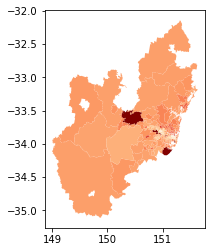

In [111]:
result=gpd.read_postgis("""
select a."SA2_NAME16",a.geom,b.score
from sa2 a join results b on a."SA2_MAIN16"=b.area_id""",conn)
result.plot(column='score',cmap='OrRd')

<AxesSubplot:>

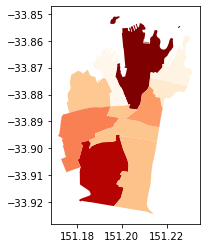

In [112]:
result3=gpd.read_postgis("""
select a."SA2_NAME16",a.geom,b.score
from sa2 a join results3 b on a."SA2_MAIN16"=b.area_id""",conn)
result3.plot(column='score',cmap='OrRd')

In [ ]:
conn.close()
db.dispose()